ResNet18, 34, 50, VIP, MVP, DINO

In [2]:
from pathlib import Path
import zarr
from tqdm import trange


import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [3]:
from src.models.encoders import models

**All Files Loading Info**


In [44]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path("/home/ubuntu/semrep")
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"

# Output path
output_path = project_root / "embeddings"

In [6]:
# Load the data
sim = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")

datasets = {"sim": sim, "real": real}

for name, dataset in datasets.items():
    imgs = dataset["color_image2"]
    labels = dataset["action/pos"]

    print(
        f"Loaded {len(dataset['episode_ends'])} trajectories containing {imgs.shape[0]} frames of {name} data"
    )

Loaded 50 trajectories containing 24131 frames of sim data
Loaded 50 trajectories containing 27699 frames of real data


In [5]:
sim.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='action', nodes=(Node(disabled=True,…

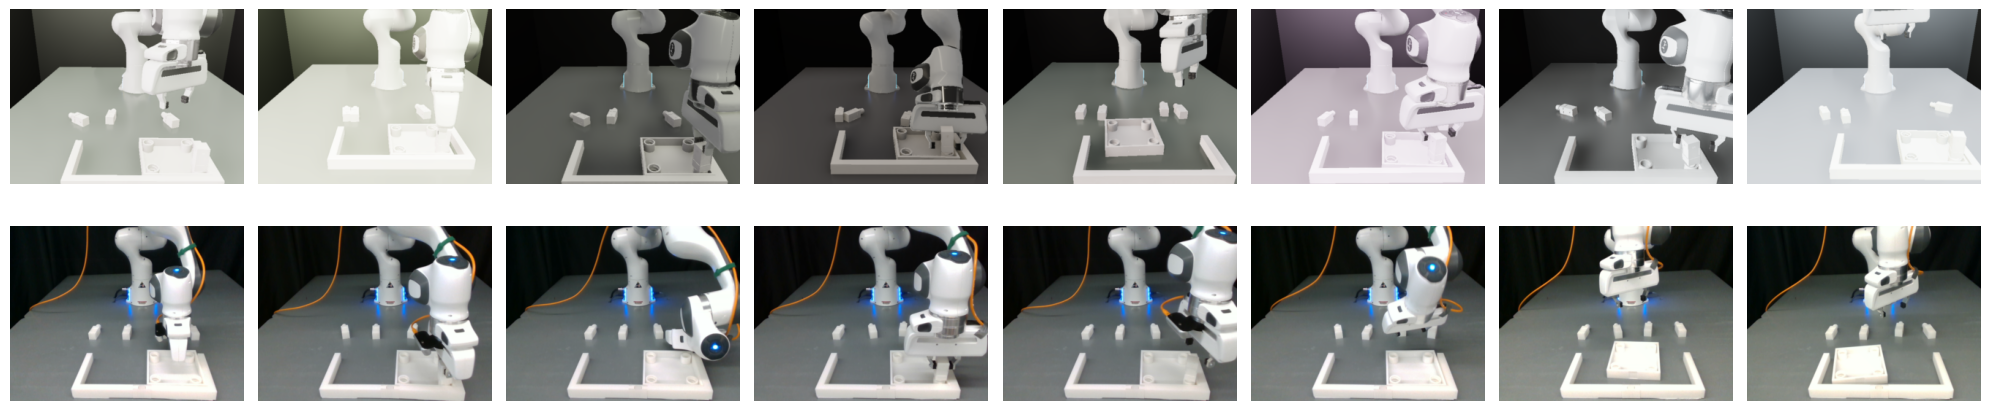

In [7]:
# Sample 8 images from each dataset
sim_indices = np.random.choice(datasets["sim"]["color_image2"].shape[0], size=8, replace=False)
real_indices = np.random.choice(datasets["real"]["color_image2"].shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# Display the sampled images
for i, idx in enumerate(sim_indices):
    axes[0, i].imshow(datasets["sim"]["color_image2"][idx])
    axes[0, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[1, i].imshow(datasets["real"]["color_image2"][idx])
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

**Load Models**

In [23]:
# Define resize transformation for MVP and VIP models
resize_transform = transforms.Compose(
    [
        transforms.ToPILImage(),  # Convert tensor to PIL image
        transforms.Resize((224, 224)),  # Resize image to 224x224
        transforms.ToTensor(),  # Convert PIL image back to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize image
    ]
)

In [34]:
def generate_embeddings(
    model,
    images,
    num_samples=None,  # None for all
    batch_size=200,
):

    # List to store embeddings for each group
    embedding_batches = []

    if num_samples is None:
        num_samples = images.shape[0]
        indices = np.arange(num_samples)
    else:
        indices = np.random.choice(images.shape[0], size=num_samples, replace=False)

    # Embedding generation loop
    with torch.no_grad():

        for i in trange(0, num_samples, batch_size, desc="Processing"):
            batch_indices = indices[i : i + batch_size]
            batch = (
                torch.stack([resize_transform(img) for img in images[batch_indices]])
                .float()
                .cuda()
            )

            embeddings = model(batch).cpu()
            embedding_batches.append(embeddings)

    # Concatenate all embeddings
    embeddings = torch.cat(embedding_batches)

    return embeddings

In [8]:
models.keys()

dict_keys(['VIP', 'ResNet18', 'ResNet34', 'ResNet50', 'MVP', 'dinov2'])

In [45]:
model_name = "ResNet18"

m: torch.nn.Module = models[model_name]().to(device)

/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/ubuntu/miniforge3/envs/sr/lib/python3.10/site-packages/r3m/__init__.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly

In [52]:
def process_dataset(m, dataset, dataset_type, num_samples=None, batch_size=1024):
    # Generate embeddings
    embeddings = generate_embeddings(
        m,
        dataset["color_image2"],
        num_samples=num_samples,
        batch_size=batch_size,
    ).numpy()

    # Make a split array for the embeddings into train and eval according to 90/10 split of trajectories
    split_index = dataset["episode_ends"][-5]

    # Split the embeddings into train and eval
    train_flag = np.zeros(embeddings.shape[0], dtype=bool)
    train_flag[:split_index] = True

    # Create a flag to indicate the dataset type (sim or real)
    dataset_flag = np.full(embeddings.shape[0], dataset_type, dtype=str)

    return embeddings, dataset["action/pos"], train_flag, dataset_flag

Processing: 100%|██████████| 28/28 [02:04<00:00,  4.45s/it]

51830 51830 51830 51830
Sim data: 0
Real data: 0


In [ ]:
# Process sim data
sim_embeddings, sim_labels, sim_train_flag, sim_dataset_flag = process_dataset(
    m, datasets["sim"], "sim"
)

# Process real data
real_embeddings, real_labels, real_train_flag, real_dataset_flag = process_dataset(
    m, datasets["real"], "real"
)

# Combine sim and real data
combined_embeddings = np.vstack((sim_embeddings, real_embeddings))
combined_labels = np.vstack((sim_labels, real_labels))
combined_train_flag = np.concatenate((sim_train_flag, real_train_flag))
combined_dataset_flag = np.concatenate((sim_dataset_flag, real_dataset_flag))

# Put together the embeddings, the labels, the split flags, and the dataset flags into a dictionary
data = {
    "embeddings": combined_embeddings,
    "labels": combined_labels,
    "train_flag": combined_train_flag,
    "dataset_flag": combined_dataset_flag,
}

In [54]:
# Check the length of the data
print(
    len(data["embeddings"]),
    len(data["labels"]),
    len(data["train_flag"]),
    len(data["dataset_flag"]),
)

# Optionally, you can check the distribution of sim and real data
print("Sim data:", np.sum(data["dataset_flag"] == "s"))
print("Real data:", np.sum(data["dataset_flag"] == "r"))

51830 51830 51830 51830
Sim data: 24131
Real data: 27699


In [55]:
# Save the data
np.savez(output_path / f"embeddings{model_name}.npz", **data)